In [17]:
import pandas as pd
import torch
import string
import numpy as np
import re
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [1]:
# Function to clean words by removing special characters
def clean_word(word):
    # Remove anything that's not a letter (a-z) or dot (.), and convert to lowercase
    return re.sub(r'[^a-z]', '', word.lower())

# Load the dataset
data = pd.read_csv('pokemon.csv')["name"]
words = data.to_list()
words = list(map(clean_word, words))

In [2]:
len(words)

801

In [3]:
words[:8]

['bulbasaur',
 'ivysaur',
 'venusaur',
 'charmander',
 'charmeleon',
 'charizard',
 'squirtle',
 'wartortle']

In [4]:
#build the vocabulary
chars = sorted(list(set(' '.join(words))))
print(chars)
print("###")
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos = {i:s for s,i in stoi.items()}
print(stoi)
print("###")
print(itos)

[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
###
{' ': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27, '.': 0}
###
{1: ' ', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 0: '.'}


In [5]:
# build the training and test splits
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([5384, 3]) torch.Size([5384])
torch.Size([686, 3]) torch.Size([686])
torch.Size([690, 3]) torch.Size([690])


In [6]:
Xtr.shape, Ytr.shape

(torch.Size([5384, 3]), torch.Size([5384]))

In [8]:
C = torch.randn((27, 2))

In [9]:
Xtr = torch.clamp(Xtr, max=C.size(0) - 1)
Ytr = torch.clamp(Ytr, max=C.size(0) - 1)
Xdev = torch.clamp(Xdev, max=C.size(0) - 1)
Ydev = torch.clamp(Ydev, max=C.size(0) - 1)
Xtr.shape, Ytr.shape

(torch.Size([5384, 3]), torch.Size([5384]))

In [40]:
g = torch.Generator()
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [41]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [42]:
for p in parameters:
  p.requires_grad = True
lri=[]
lossi = []
stepi= []

In [43]:
#minibatch for optimisation and learning rates

for i in range(100000):
    #forward pass
    emb = C[Xtr] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr)
    #print(loss.item())
    #backward pass
    for p in parameters:
      p.grad = None
    loss.backward()
    #update
    #lr=lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    #track statst
    stepi.append(i)
    #lri.append(lre[i])
    lossi.append(loss.log10().item())

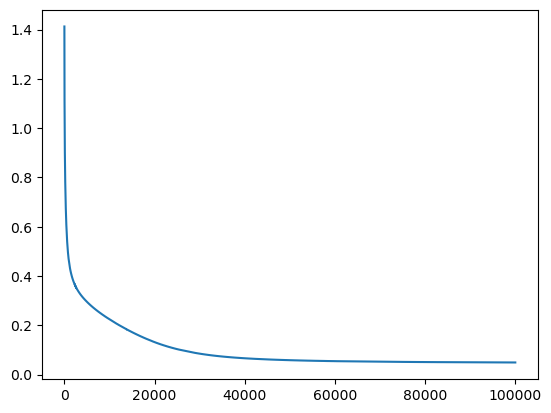

In [44]:
plt.plot(stepi,lossi)

In [45]:
print(loss.item())

1.1193265914916992


In [46]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [47]:
g = torch.Generator()

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

snove.
hitar.
flaby.
star.
sea.
munna.
pyroak.
golducklefair.
cacnea.
lopdaleo.
don.
feartic.
bee.
purr.
sableyemu.
amask.
pumplup.
lamper.
duruglyph.
polisopod.
